# Quantization aware training in Keras example

Credit : https://www.tensorflow.org/model_optimization/guide/quantization/training_example


In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Train a model for MNIST without quantization aware training 

In [2]:
# Load mnist dataset
mnist = keras.datasets.mnist

# (training dataset input, output), (testing dataset input, output)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
len(X_train) # input length of training dataset

60000

In [4]:
len(X_test) # input length of test dataset

10000

In [5]:
X_train.shape[0] # length of single vector in input dataset, will give same 60K

60000

In [6]:
X_train[0].shape # pixel matrix or shape of each training dataset

(28, 28)

In [7]:
X_train.shape # matrix of entire input training dataset shape and shape of each

(60000, 28, 28)

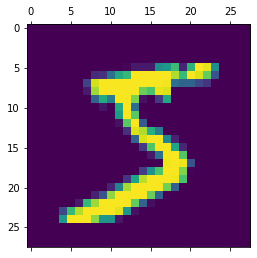

In [8]:
# visualize the image of single dataset, pixel of 28 x 28
# plt.matshow(X_train[0].shape) # ValueError: not enough values to unpack (expected 2, got 1)
plt.matshow(X_train[0]) # visualize single matrix

In [9]:
# verify the same with output dataset
y_train[0]

5

In [10]:
# Normalize / Scale the input image so that each pixel value is between 0 to 1, since each pixel is of 256 (0 to 255)
X_train = X_train / 255
X_test = X_test / 255

In [11]:
# Define the model architecture.
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28)),
    keras.layers.Reshape(target_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

In [12]:
# Train the digit classification model
model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [13]:
model.fit(X_train, y_train, epochs=2, validation_split=0.1)

Epoch 1/2
1688/1688 [==============================] - 15s 9ms/step - loss: 0.2778 - accuracy: 0.9251 - val_loss: 0.1077 - val_accuracy: 0.9710
Epoch 2/2
1688/1688 [==============================] - 13s 8ms/step - loss: 0.1058 - accuracy: 0.9692 - val_loss: 0.0724 - val_accuracy: 0.9795


# Clone and fine-tune pre-trained model with quantization aware training
Apply **quantization aware training** to the whole model and see this in the model summary. All layers are now prefixed by "quant".

Note that the resulting model is **quantization aware** but not **_quantized_** <u>_(means the weights are float32 instead of int8)_</u>

In [14]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# q_aware_model, requires re-compile
q_aware_model.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])
q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_reshape (QuantizeWrap  (None, 28, 28, 1)        1         
 perV2)                                                          
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 26, 26, 12)       147       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 13, 13, 12)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_flatten (QuantizeWrap  (None, 2028)             1

## Train and evaluate the model against baseline
To demonstrate fine tuning after training the model for just an epoch, fine tune with quantization aware training on a subset of the training data.

In [15]:
X_train_subset = X_train[0:1000] # out of 60000
y_train_subset = y_train[0:1000]
# y_train_subset.shape
# X_train_subset
# y_train_subset # first number is 5 (means first output number is '5')
X_train_subset.shape

(1000, 28, 28)

In [16]:
# I'm assuming train the model on flattened dataset
q_aware_model.fit(X_train_subset, y_train_subset, batch_size=500, epochs=1, validation_split=0.1)

2/2 [==============================] - 2s 435ms/step - loss: 0.0922 - accuracy: 0.9778 - val_loss: 0.1142 - val_accuracy: 0.9800


### For this example, there is minimal to no loss in test accuracy after quantization aware training, compared to the baseline.

In [17]:
_, baseline_model_accuracy = model.evaluate(X_test, y_test, verbose=0)
_, q_aware_model_accuracy = q_aware_model.evaluate(X_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

Baseline test accuracy: 0.9765999913215637
Quant test accuracy: 0.9767000079154968


# Create quantized model for TFLite backend
After this, you have an actually quantized model with int8 weights and uint8 activations.

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\39762\AppData\Local\Temp\tmp5idrmik3\assets


INFO:tensorflow:Assets written to: C:\Users\39762\AppData\Local\Temp\tmp5idrmik3\assets


# See persistence of accuracy from TF to TFLite
Define a helper function to evaluate the TF Lite model on the test dataset.

In [19]:
import numpy as np

def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_data in enumerate(X_test):
        if(i % 1000) == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
            # Pre-processing: add batch dimension and convert to float32 to match with the model's input data format.
        test_data = np.expand_dims(test_data, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_data)
            
        # Run inference
        interpreter.invoke()
            
        # Post-processing: remove batch dimension and find the digit with highest probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == y_test).mean()
    
    return accuracy

##### You evaluate the quantized model and see that the accuracy from TensorFlow persists to the TFLite backend.

In [20]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)
print('Quant TF test accuracy:', q_aware_model_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Quant TFLite test_accuracy: 0.9767
Quant TF test accuracy: 0.9767000079154968


# See 4x smaller model from quantization
##### You create a float TFLite model and then see that the quantized TFLite model is 4x smaller.

In [21]:
import tempfile
import os

# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

INFO:tensorflow:Assets written to: C:\Users\39762\AppData\Local\Temp\tmpt1hw9yu4\assets


INFO:tensorflow:Assets written to: C:\Users\39762\AppData\Local\Temp\tmpt1hw9yu4\assets


Float model in Mb: 0.08062362670898438
Quantized model in Mb: 0.023468017578125
